In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
# data_train = np.load(savepath+'data_pd_noreg.npy')
# task = TwoLinkReaching(render=True)
# task.visualize_training_data(data_train, 0)

In [6]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100*torch.ones_like(q_lb), 100*torch.ones_like(q_ub)

In [9]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD

# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor 

In [10]:
# # Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size,
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [11]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 100
n_particles = 10
pop_size = 400

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [12]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [13]:
lip_reg = True

if lip_reg:
    controller.regularize(1)
    file_name = savepath + 'data_pd_reg'
else: 
    controller.regularize(0)
    file_name = savepath + 'data_pd_noreg'
    
_ = learner.learn(50, verbose=True)
learner.save_training_data(file_name)

Network training: 100%|██████████| 10/10 [00:00<00:00, 18.92epoch(s)/s, Training loss MSE=1.2135111]


Iteration:  0
Initial state:  tensor([ 2.4841, -0.0582,  0.0000,  0.0000])
avg. decision time:  0.012290596961975098
obs. reward:  -1180.453
act. reward:  -4.335348


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.32epoch(s)/s, Training loss MSE=0.2888586]


Iteration:  1
Initial state:  tensor([2.3779, 0.1967, 0.0000, 0.0000])
avg. decision time:  1.0482946145534515
obs. reward:  -750.7608
act. reward:  -0.65488416


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.39epoch(s)/s, Training loss MSE=0.16107091]


Iteration:  2
Initial state:  tensor([2.3903, 0.1252, 0.0000, 0.0000])
avg. decision time:  1.0579659521579743
obs. reward:  -691.343
act. reward:  -0.16005558


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.35epoch(s)/s, Training loss MSE=0.2807243]


Iteration:  3
Initial state:  tensor([2.4318, 0.1233, 0.0000, 0.0000])
avg. decision time:  1.056524065732956
obs. reward:  -1588.9109
act. reward:  -1.2094119


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.64epoch(s)/s, Training loss MSE=0.21610205]


Iteration:  4
Initial state:  tensor([2.4134, 0.0376, 0.0000, 0.0000])
avg. decision time:  1.0589168024063111
obs. reward:  -639.8867
act. reward:  -1.4819821


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.24epoch(s)/s, Training loss MSE=0.18138096]


Iteration:  5
Initial state:  tensor([2.4607, 0.0821, 0.0000, 0.0000])
avg. decision time:  1.0584253108501434
obs. reward:  -594.41974
act. reward:  -0.52057433


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.95epoch(s)/s, Training loss MSE=0.17482726]


Iteration:  6
Initial state:  tensor([ 2.2718, -0.0972,  0.0000,  0.0000])
avg. decision time:  1.0605370151996611
obs. reward:  -1149.1626
act. reward:  -0.8572958


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.71epoch(s)/s, Training loss MSE=0.15497373]


Iteration:  7
Initial state:  tensor([2.3997, 0.0113, 0.0000, 0.0000])
avg. decision time:  1.057338089942932
obs. reward:  -1241.0298
act. reward:  -0.21417831


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.48epoch(s)/s, Training loss MSE=0.13345131]


Iteration:  8
Initial state:  tensor([2.3575e+00, 1.8006e-03, 0.0000e+00, 0.0000e+00])
avg. decision time:  1.0610991442203521
obs. reward:  -873.16766
act. reward:  -0.432792


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.35epoch(s)/s, Training loss MSE=0.14311191]


Iteration:  9
Initial state:  tensor([ 2.2232, -0.0866,  0.0000,  0.0000])
avg. decision time:  1.0874578738212586
obs. reward:  -978.9649
act. reward:  -1.9666176


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.22epoch(s)/s, Training loss MSE=0.11787043]


Iteration:  10
Initial state:  tensor([ 2.3003, -0.1156,  0.0000,  0.0000])
avg. decision time:  1.0613321363925934
obs. reward:  -183.72012
act. reward:  -0.58229905


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.13epoch(s)/s, Training loss MSE=0.10560084]


Iteration:  11
Initial state:  tensor([2.2647, 0.0864, 0.0000, 0.0000])
avg. decision time:  1.0608999001979829
obs. reward:  -1312.0938
act. reward:  -0.13832855


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.03epoch(s)/s, Training loss MSE=0.094216496]


Iteration:  12
Initial state:  tensor([2.3893, 0.2025, 0.0000, 0.0000])
avg. decision time:  1.0588597583770751
obs. reward:  -176.93411
act. reward:  -0.96392906


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.05s/epoch(s), Training loss MSE=0.0827566] 


Iteration:  13
Initial state:  tensor([2.5268, 0.0106, 0.0000, 0.0000])
avg. decision time:  1.0603066134452819
obs. reward:  -168.79521
act. reward:  -1.3353477


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.12s/epoch(s), Training loss MSE=0.07640082]


Iteration:  14
Initial state:  tensor([ 2.3863, -0.0224,  0.0000,  0.0000])
avg. decision time:  1.061376268863678
obs. reward:  -151.44609
act. reward:  -1.4566613


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.18s/epoch(s), Training loss MSE=0.067431934]


Iteration:  15
Initial state:  tensor([2.3029e+00, 6.5374e-04, 0.0000e+00, 0.0000e+00])
avg. decision time:  1.0604243516921996
obs. reward:  -144.8308
act. reward:  -1.4169348


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.22s/epoch(s), Training loss MSE=0.060127985]


Iteration:  16
Initial state:  tensor([2.5068, 0.1306, 0.0000, 0.0000])
avg. decision time:  1.0617149126529695
obs. reward:  -174.72083
act. reward:  -1.6640866


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.34s/epoch(s), Training loss MSE=0.055769335]


Iteration:  17
Initial state:  tensor([ 2.3721, -0.1038,  0.0000,  0.0000])
avg. decision time:  1.060644612312317
obs. reward:  -138.55093
act. reward:  -1.5855092


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.35s/epoch(s), Training loss MSE=0.053901482]


Iteration:  18
Initial state:  tensor([2.2946, 0.0375, 0.0000, 0.0000])
avg. decision time:  1.0586474990844728
obs. reward:  -146.54573
act. reward:  -1.6192725


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.29s/epoch(s), Training loss MSE=0.04978718]


Iteration:  19
Initial state:  tensor([ 2.2519, -0.0043,  0.0000,  0.0000])
avg. decision time:  1.058619157075882
obs. reward:  -132.6673
act. reward:  -1.5808018


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.56s/epoch(s), Training loss MSE=0.061021287]


Iteration:  20
Initial state:  tensor([ 2.3463, -0.0442,  0.0000,  0.0000])
avg. decision time:  1.0626074934005738
obs. reward:  -140.41101
act. reward:  -1.6446211


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.58s/epoch(s), Training loss MSE=0.05464363]


Iteration:  21
Initial state:  tensor([ 2.3819, -0.0230,  0.0000,  0.0000])
avg. decision time:  1.0582464027404785
obs. reward:  -194.57231
act. reward:  -2.2283068


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.71s/epoch(s), Training loss MSE=0.046810843]


Iteration:  22
Initial state:  tensor([ 2.3675, -0.0194,  0.0000,  0.0000])
avg. decision time:  1.0628068256378174
obs. reward:  -194.28163
act. reward:  -0.7919509


Network training: 100%|██████████| 10/10 [00:17<00:00,  1.77s/epoch(s), Training loss MSE=0.042132996]


Iteration:  23
Initial state:  tensor([ 2.5638, -0.0281,  0.0000,  0.0000])
avg. decision time:  1.0602826356887818
obs. reward:  -168.17493
act. reward:  -1.5334625


Network training: 100%|██████████| 10/10 [00:18<00:00,  1.86s/epoch(s), Training loss MSE=0.03913923]


Iteration:  24
Initial state:  tensor([2.5522, 0.2681, 0.0000, 0.0000])
avg. decision time:  1.0609401404857635
obs. reward:  -174.61607
act. reward:  -1.8753588


Network training: 100%|██████████| 10/10 [00:18<00:00,  1.83s/epoch(s), Training loss MSE=0.040372625]


Iteration:  25
Initial state:  tensor([ 2.2559, -0.0725,  0.0000,  0.0000])
avg. decision time:  1.0611116683483124
obs. reward:  -137.60907
act. reward:  -1.3389814


Network training: 100%|██████████| 10/10 [00:20<00:00,  2.00s/epoch(s), Training loss MSE=0.035404827]


Iteration:  26
Initial state:  tensor([2.5242, 0.2043, 0.0000, 0.0000])
avg. decision time:  1.0606723606586457
obs. reward:  -188.01007
act. reward:  -1.5430667


Network training: 100%|██████████| 10/10 [00:20<00:00,  2.05s/epoch(s), Training loss MSE=0.038930066]


Iteration:  27
Initial state:  tensor([ 2.4210, -0.2507,  0.0000,  0.0000])
avg. decision time:  1.0598069155216217
obs. reward:  -137.22955
act. reward:  -1.4006101


Network training: 100%|██████████| 10/10 [00:20<00:00,  2.08s/epoch(s), Training loss MSE=0.037504736]


Iteration:  28
Initial state:  tensor([2.3293, 0.0296, 0.0000, 0.0000])
avg. decision time:  1.061668791770935
obs. reward:  -149.23473
act. reward:  -1.4445871


Network training: 100%|██████████| 10/10 [00:22<00:00,  2.24s/epoch(s), Training loss MSE=0.032822933]


Iteration:  29
Initial state:  tensor([ 2.3953, -0.1012,  0.0000,  0.0000])
avg. decision time:  1.061333382129669
obs. reward:  -174.51323
act. reward:  -1.1389513


Network training: 100%|██████████| 10/10 [00:22<00:00,  2.28s/epoch(s), Training loss MSE=0.032296855]


Iteration:  30
Initial state:  tensor([ 2.3923, -0.0830,  0.0000,  0.0000])
avg. decision time:  1.0615092527866363
obs. reward:  -145.75478
act. reward:  -1.3822163


Network training: 100%|██████████| 10/10 [00:23<00:00,  2.36s/epoch(s), Training loss MSE=0.028615514]


Iteration:  31
Initial state:  tensor([2.4299, 0.0552, 0.0000, 0.0000])
avg. decision time:  1.059549593925476
obs. reward:  -160.59613
act. reward:  -1.513138


Network training: 100%|██████████| 10/10 [00:22<00:00,  2.22s/epoch(s), Training loss MSE=0.027400719]


Iteration:  32
Initial state:  tensor([2.2839, 0.1290, 0.0000, 0.0000])
avg. decision time:  1.059487031698227
obs. reward:  -144.17538
act. reward:  -1.5307802


Network training: 100%|██████████| 10/10 [00:25<00:00,  2.53s/epoch(s), Training loss MSE=0.05566899]


Iteration:  33
Initial state:  tensor([ 2.4322, -0.0616,  0.0000,  0.0000])
avg. decision time:  1.0655165088176728
obs. reward:  -161.53502
act. reward:  -1.3400458


Network training: 100%|██████████| 10/10 [00:25<00:00,  2.57s/epoch(s), Training loss MSE=0.028974637]


Iteration:  34
Initial state:  tensor([2.2396, 0.0067, 0.0000, 0.0000])
avg. decision time:  1.0610131895542145
obs. reward:  -249.09575
act. reward:  -1.0855073


Network training: 100%|██████████| 10/10 [00:26<00:00,  2.67s/epoch(s), Training loss MSE=0.024996659]


Iteration:  35
Initial state:  tensor([2.3178, 0.0103, 0.0000, 0.0000])
avg. decision time:  1.0617371535301208
obs. reward:  -161.38622
act. reward:  -1.1874585


Network training: 100%|██████████| 10/10 [00:25<00:00,  2.57s/epoch(s), Training loss MSE=0.038406964]


Iteration:  36
Initial state:  tensor([2.4455, 0.0317, 0.0000, 0.0000])
avg. decision time:  1.0635373377799988
obs. reward:  -153.66212
act. reward:  -1.6773757


Network training: 100%|██████████| 10/10 [00:28<00:00,  2.83s/epoch(s), Training loss MSE=0.038728584]


Iteration:  37
Initial state:  tensor([ 2.2370, -0.0954,  0.0000,  0.0000])
avg. decision time:  1.0620349073410034
obs. reward:  -180.56499
act. reward:  -0.8157677


Network training: 100%|██████████| 10/10 [00:28<00:00,  2.82s/epoch(s), Training loss MSE=0.024993]  


Iteration:  38
Initial state:  tensor([ 2.5026, -0.0515,  0.0000,  0.0000])
avg. decision time:  1.059683585166931
obs. reward:  -223.3467
act. reward:  -0.65050936


Network training: 100%|██████████| 10/10 [00:29<00:00,  2.96s/epoch(s), Training loss MSE=0.022961391]


Iteration:  39
Initial state:  tensor([ 2.3449, -0.1075,  0.0000,  0.0000])
avg. decision time:  1.060995213985443
obs. reward:  -156.17943
act. reward:  -1.2295091


Network training: 100%|██████████| 10/10 [00:29<00:00,  2.95s/epoch(s), Training loss MSE=0.029843166]


Iteration:  40
Initial state:  tensor([ 2.2065, -0.1397,  0.0000,  0.0000])
avg. decision time:  1.061629638671875
obs. reward:  -131.94931
act. reward:  -1.1307281


Network training: 100%|██████████| 10/10 [00:31<00:00,  3.12s/epoch(s), Training loss MSE=0.035923615]


Iteration:  41
Initial state:  tensor([ 2.3967, -0.1548,  0.0000,  0.0000])
avg. decision time:  1.0629507565498353
obs. reward:  -1328.834
act. reward:  -1.1669428


Network training: 100%|██████████| 10/10 [00:31<00:00,  3.19s/epoch(s), Training loss MSE=0.030583022]


Iteration:  42
Initial state:  tensor([2.4740, 0.0520, 0.0000, 0.0000])
avg. decision time:  1.0600519156455994
obs. reward:  -252.13326
act. reward:  -0.62386


Network training: 100%|██████████| 10/10 [00:32<00:00,  3.21s/epoch(s), Training loss MSE=0.024153924]


Iteration:  43
Initial state:  tensor([ 2.2262, -0.1329,  0.0000,  0.0000])
avg. decision time:  1.060984469652176
obs. reward:  -182.03362
act. reward:  -0.77073395


Network training: 100%|██████████| 10/10 [00:33<00:00,  3.35s/epoch(s), Training loss MSE=0.024877822]


Iteration:  44
Initial state:  tensor([ 2.4051, -0.0577,  0.0000,  0.0000])
avg. decision time:  1.0634399461746216
obs. reward:  -149.83693
act. reward:  -1.3836497


Network training: 100%|██████████| 10/10 [00:34<00:00,  3.43s/epoch(s), Training loss MSE=0.015580465]


Iteration:  45
Initial state:  tensor([2.2706, 0.0327, 0.0000, 0.0000])
avg. decision time:  1.063068495988846
obs. reward:  -147.45303
act. reward:  -1.0948988


Network training: 100%|██████████| 10/10 [00:34<00:00,  3.47s/epoch(s), Training loss MSE=0.021729443]


Iteration:  46
Initial state:  tensor([ 2.3745, -0.0593,  0.0000,  0.0000])
avg. decision time:  1.0628197991847992
obs. reward:  -148.57626
act. reward:  -1.2879041


Network training: 100%|██████████| 10/10 [00:35<00:00,  3.56s/epoch(s), Training loss MSE=0.05189533]


Iteration:  47
Initial state:  tensor([ 2.3473, -0.1425,  0.0000,  0.0000])
avg. decision time:  1.0638077414035798
obs. reward:  -149.31029
act. reward:  -0.96691275


Network training: 100%|██████████| 10/10 [00:36<00:00,  3.68s/epoch(s), Training loss MSE=0.019149268]


Iteration:  48
Initial state:  tensor([ 2.3550, -0.0205,  0.0000,  0.0000])
avg. decision time:  1.0665603756904602
obs. reward:  -372.0564
act. reward:  -2.3425364


Network training: 100%|██████████| 10/10 [00:35<00:00,  3.57s/epoch(s), Training loss MSE=0.021864679]

Iteration:  49
Initial state:  tensor([ 2.3273, -0.1230,  0.0000,  0.0000])
avg. decision time:  1.0637227404117584
obs. reward:  -148.40997
act. reward:  -1.3961886


In [14]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  1.0612739539146423
obs. reward:  -705.4328
act. reward:  -0.8817823


In [15]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(3.0123, grad_fn=<MeanBackward0>)
tensor(3.0282, grad_fn=<StdBackward0>)


In [16]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [17]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [18]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

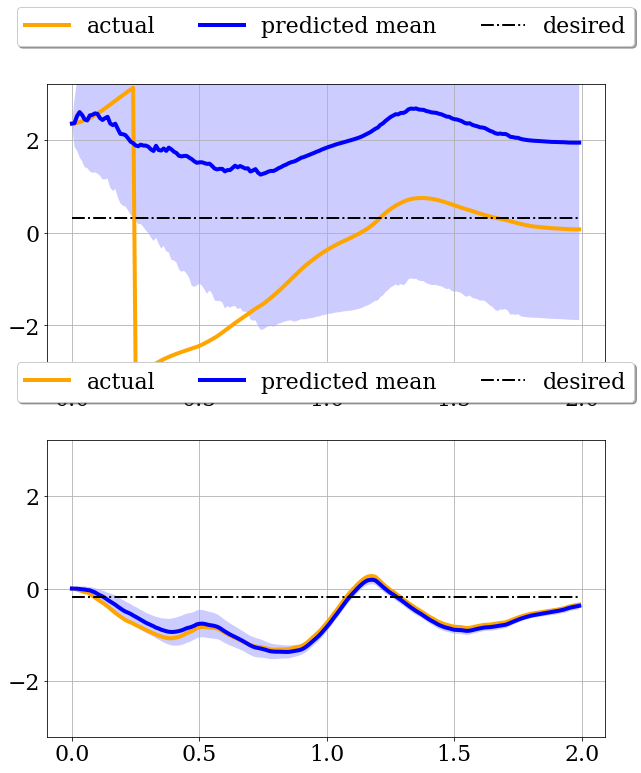

In [19]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')